# Avalanche Data Project

## Introduction

The main idea of this project is to generate a well calibrated avalanche report based on observations of winter conditions typically performed by backcountry skiers and snowboarders. These reports provide very valuable information for not only backcountry users but also highway management in mountainous terrain. Currently the reports are carried out by publically and government support. This avalanche project uses observations from the Utah Avalanche Center (UAC) Website (https://utahavalanchecenter.org) which hosts reports that cover the entire state. This document explains my thought process on  how to make a model for predicting the likelyhood of an avalanche based on previous day observations. 

In [40]:
import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import datetime
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

pd.__version__

'1.5.3'

I got some good infor on converting html files into pandas dataframes from this article, https://towardsdatascience.com/how-to-get-tables-from-websites-into-pandas-dataframes-e82bd8a0ac59. `

## Collecting Observation Data

### Observations List

First we get a list of observations from the UAC's website before we draw out each avalanche/conditions observation and log that in a table of observations or catalog. Each observation in the catalog holds whatever data that observer reports (weather, tests, descriptions, avalanche, etc). First we need to extract a list of all the observations made on the site's observation site (https://utahavalanchecenter.org/observations).

In [41]:
avy_center_url = 'http://utahavalanchecenter.org'
observations_url = avy_center_url + '/observations'
page = requests.get(observations_url)
soup = BeautifulSoup(page.content, 'html.parser')
tbl = soup.find("table")
#print(tbl.dtype)
page_obs = pd.read_html(str(tbl),extract_links ='all')[0]
page_obs.head()

,"(Date, None)","(Region, None)","(, None)","(Observer, None)"
0,"(3/28/2023, None)","(Provo, None)","(Observation: Aspen Grove, /observation/77490)","(Owen, None)"
1,"(3/27/2023, None)","(Salt Lake, None)","(Avalanche: Butler Fork, /avalanche/77487)","(Patty Pow Pow, None)"
2,"(3/27/2023, None)","(Salt Lake, None)","(Accident: Oquirrh Mountains, /avalanche/77465)","(UAC Staff, None)"
3,"(3/27/2023, None)","(Salt Lake, None)","(Avalanche: Little Superior, /avalanche/77464)","(slp, None)"
4,"(3/27/2023, None)","(Salt Lake, None)","(Observation: South Face, /observation/77463)","(W Ambler, None)"


The main problem with the extract_links is it converts everying into a tuple. We want to eliminate the tuples and rewrite the "(,None)" column as "link_extensions".

In [42]:
old_columns = page_obs.columns

In [43]:
#change names
page_obs[['Date', 'a']]= pd.DataFrame(page_obs[old_columns[0]].tolist(), index=page_obs.index)
page_obs[['Region', 'b']]= pd.DataFrame(page_obs[old_columns[1]].tolist(), index=page_obs.index) 
page_obs[['Observation Title', 'extension']]= pd.DataFrame(page_obs[old_columns[2]].tolist(), index=page_obs.index) 
page_obs[['Observer', 'd']]= pd.DataFrame(page_obs[old_columns[3]].tolist(), index=page_obs.index)

#remove old columns & columns with none
page_obs=page_obs.drop(old_columns, axis=1)
page_obs=page_obs.drop(['a','b','d'], axis=1)
page_obs.head()

,Date,Region,Observation Title,extension,Observer
0,3/28/2023,Provo,Observation: Aspen Grove,/observation/77490,Owen
1,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
2,3/27/2023,Salt Lake,Accident: Oquirrh Mountains,/avalanche/77465,UAC Staff
3,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
4,3/27/2023,Salt Lake,Observation: South Face,/observation/77463,W Ambler


Lets wrap that all into some nice functions.

In [44]:
def get_page_obs(url):
    '''returns a dataframe of avalanche observations from url. Data in df
    includes Date, Region, Avalanche/Observation, (url) extension, and
    observor'''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    tbl=soup.find("table")
    page_obs = pd.read_html(str(tbl), extract_links='all')[0]
    page_obs = clean_page_obs(page_obs)
    return page_obs

def clean_page_obs(page_obs):
    '''Cleans up the html parser's interpretation of the observation list'''
    old_columns = page_obs.columns
    #change names 
    page_obs[['Date', 'a']]= pd.DataFrame(page_obs[old_columns[0]].tolist(), index=page_obs.index)
    page_obs[['Region', 'b']]= pd.DataFrame(page_obs[old_columns[1]].tolist(), index=page_obs.index)
    page_obs[['Observation Title', 'extension']]= pd.DataFrame(page_obs[old_columns[2]].tolist(), index=page_obs.index)
    page_obs[['Observer', 'd']]= pd.DataFrame(page_obs[old_columns[3]].tolist(), index=page_obs.index)
    #remove old columns & columns with none
    page_obs=page_obs.drop(old_columns, axis=1)
    page_obs=page_obs.drop(['a','b','d'], axis=1)
    return page_obs

page_obs = get_page_obs(observations_url)
page_obs.head()


,Date,Region,Observation Title,extension,Observer
0,3/28/2023,Provo,Observation: Aspen Grove,/observation/77490,Owen
1,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
2,3/27/2023,Salt Lake,Accident: Oquirrh Mountains,/avalanche/77465,UAC Staff
3,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
4,3/27/2023,Salt Lake,Observation: South Face,/observation/77463,W Ambler


Next lets try iterating through each of the pages. The starting page url is https://utahavalanchecenter.org/observations. When clicked on the next page we get https://utahavalanchecenter.org/observations?page=1. So lets just keep stepping up from there.

In [45]:
n_pages = 5
page_obs = pd.DataFrame()
entries_start= page_obs.shape
for page in range(n_pages):
    url = observations_url
    if page != 0:
        url = url + f"?page={page}"
    page_obs_new = get_page_obs(url)
    page_obs = pd.concat([page_obs, page_obs_new])
page_obs = page_obs.reset_index(drop=True)
entries_end = page_obs.shape
print('Entries started with', entries_start,'and ended with', entries_end)
print(page_obs.iloc[0])
print(page_obs.iloc[-1])

Entries started with (0, 0) and ended with (250, 5)
Date                                3/28/2023
Region                                  Provo
Observation Title    Observation: Aspen Grove
extension                  /observation/77490
Observer                                 Owen
Name: 0, dtype: object
Date                               3/11/2023
Region                                 Logan
Observation Title    Avalanche: River Chutes
extension                   /avalanche/76738
Observer                            Pagnucco
Name: 249, dtype: object


In [46]:
page_obs

,Date,Region,Observation Title,extension,Observer
0,3/28/2023,Provo,Observation: Aspen Grove,/observation/77490,Owen
1,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
2,3/27/2023,Salt Lake,Accident: Oquirrh Mountains,/avalanche/77465,UAC Staff
3,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
4,3/27/2023,Salt Lake,Observation: South Face,/observation/77463,W Ambler
...,...,...,...,...,...
245,3/12/2023,Logan,Observation: Cherry Creek Canyon,/observation/76605,William Rouse
246,3/11/2023,Skyline,Avalanche: Avalanche Alley,/avalanche/77134,Kobernik
247,3/11/2023,Skyline,Avalanche: Forks of the Huntington,/avalanche/76518,Brett Kobernik-Jeremy Larson
248,3/11/2023,Uintas,Avalanche: Upper Chalk Creek,/avalanche/76894,Torrey


#### Custom Date Range
Utah Avalanche also allows for you to look back into past season's avalanches using the custom date range. Given the range from 01/01/2021 to 12/01/2021 the output url is: https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021.

In [47]:
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 1, 1)
print(end_date-start_date)
print(type(start_date))

365 days, 0:00:00
<class 'datetime.datetime'>


In [48]:
def generate_url(start_date, end_date):
    return f"https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D={start_date.month:02d}/{start_date.day:02d}/{start_date.year}&fodv%5Bmax%5D%5Bdate%5D={end_date.month:02d}/{end_date.day:02d}/{end_date.year}"
    
gen_url=generate_url(start_date = datetime.datetime(2021,1,1), end_date = datetime.datetime(2021, 12,1))
if gen_url == 'https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021':
    print('The urls match:', gen_url)
else:
    print('The urls failed:')
    print(gen_url)
    print('https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021')

The urls match: https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021


For a large enough range there will be multiple pages and we will need to iterate through those. To step through the pages we just need to add the string '&page=page_num' to the generated url where page_num is the page number.

In [49]:
#collect the reports from December 2022. 
start_date = datetime.datetime(2022, 12,1)
end_date = datetime.datetime(2022, 12, 31)
start_url = generate_url(start_date, end_date)
page_num = 0
observations = pd.DataFrame()
while True:
    try:
        if page_num != 0:
            data_url = start_url + f"&page={page_num}"
        else:
            data_url = start_url
        page_obs_new = get_page_obs(data_url)
        observations = pd.concat([observations, page_obs_new])
        page_num += 1
    except:
        break
observations = observations.reset_index(drop=True)
observations

,Date,Region,Observation Title,extension,Observer
0,12/31/2022,Ogden,Avalanche: Rodeo Ridge,/avalanche/72835,Bill Brandt
1,12/31/2022,Ogden,Avalanche: Cutler Basin,/avalanche/72774,Joe
2,12/31/2022,Logan,Observation: Beaver Mountain Backcountry,/observation/72698,"weed, pagnucco"
3,12/31/2022,Salt Lake,Avalanche: Willows,/avalanche/72713,McKay
4,12/31/2022,Provo,Avalanche: North Fork Provo R.,/avalanche/72726,
...,...,...,...,...,...
519,12/1/2022,Provo,Observation: Provo,/observation/70921,Susan S
520,12/1/2022,Salt Lake,Observation: Brighton Perimeter,/observation/70924,"Talty, Coyne, Gill"
521,12/1/2022,Salt Lake,Observation: West ridge,/observation/70928,"Will Ambler, Will Marin"
522,12/1/2022,Salt Lake,Avalanche: Mineral Fork,/avalanche/70931,Julian Kallanian


In [50]:
#lets put that in a function
def get_obs(start_date, end_date):
    '''returns a dataframe of the observations on the UAC website. '''
    start_url = generate_url(start_date, end_date)
    page_num = 0
    observations = pd.DataFrame()
    while True:
        try:
            if page_num != 0:
                data_url = start_url + f"&page={page_num}"
            else:
                data_url = start_url
            page_obs_new = get_page_obs(data_url)
            observations = pd.concat([observations, page_obs_new])
            page_num += 1
        except:
            #if the page can't be loaded then we've reached the end of available obs
            break
    observations = observations.reset_index(drop=True)
    #TODO: if no start date or end date give this season's observations
    return observations

#### Season Data
In general a ski season in the Wasatch typically lasts from the late fall (October or November) to mid spring (April or May). Therefore we can define a season easily between the dry months of July and August. If we wanted to collect the data from the current season we need only to look between "today" and the beginning of that season. 

In [51]:
today = datetime.date.today()
print(today, type(today))
def get_season_start(date):
    '''returns the beginning of the season as defined between the last August and the end of July'''
    start_day = 1
    start_month = 8
    end_month = 7
    if date.month < 7:
        start_year = date.year-1
    else:
        start_year = date.year
    return datetime.datetime(start_year, start_month, start_day)
print(get_season_start(today))

2023-03-28 <class 'datetime.date'>
2022-08-01 00:00:00


In [52]:
def get_season_obs(date = datetime.date.today()):
    '''fetches the observations of the season for the date specified'''
    season_start = get_season_start(date)
    return get_obs(season_start, date)
season_obs = get_season_obs()
season_obs

,Date,Region,Observation Title,extension,Observer
0,3/28/2023,Provo,Observation: Aspen Grove,/observation/77490,Owen
1,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
2,3/27/2023,Salt Lake,Accident: Oquirrh Mountains,/avalanche/77465,UAC Staff
3,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
4,3/27/2023,Salt Lake,Observation: South Face,/observation/77463,W Ambler
...,...,...,...,...,...
2073,10/24/2022,Salt Lake,Observation: Little Cottonwood Canyon,/observation/69799,
2074,10/23/2022,Salt Lake,Avalanche: High Greeley,/avalanche/69798,Nate Fillnow
2075,10/23/2022,Salt Lake,Avalanche: Cardiac Ridge,/avalanche/69797,UAC Staff
2076,10/23/2022,Salt Lake,Avalanche: Baldy,/avalanche/69788,UAC Staff - Meisenheimer


### Sorting Observations
Filtering for regions, avalanches vs observations, and others. 

In [53]:
season_obs.shape[0]

2078

#### Filter Regions

In [54]:
#What are the avalanche regions that got avalanches this season?
print(season_obs.Region.value_counts())

Salt Lake     1013
Logan          311
Ogden          188
Uintas         186
Provo          181
Moab           107
Skyline         54
Southwest       22
Abajos          10
SE Idaho         5
State-wide       1
Name: Region, dtype: int64


In [55]:
#This season I'm generally staying in the Salt Lake region of the Wasatch
saltLake_obs = season_obs.loc[season_obs.Region == "Salt Lake"]
saltLake_obs

,Date,Region,Observation Title,extension,Observer
1,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
2,3/27/2023,Salt Lake,Accident: Oquirrh Mountains,/avalanche/77465,UAC Staff
3,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
4,3/27/2023,Salt Lake,Observation: South Face,/observation/77463,W Ambler
5,3/27/2023,Salt Lake,Avalanche: Long John Silver,/avalanche/77461,VR
...,...,...,...,...,...
2073,10/24/2022,Salt Lake,Observation: Little Cottonwood Canyon,/observation/69799,
2074,10/23/2022,Salt Lake,Avalanche: High Greeley,/avalanche/69798,Nate Fillnow
2075,10/23/2022,Salt Lake,Avalanche: Cardiac Ridge,/avalanche/69797,UAC Staff
2076,10/23/2022,Salt Lake,Avalanche: Baldy,/avalanche/69788,UAC Staff - Meisenheimer


#### Filter Avalanche vs Observation

In [56]:
season_obs['Observation Title'].str.split(':').str[0]

0       Observation
1         Avalanche
2          Accident
3         Avalanche
4       Observation
           ...     
2073    Observation
2074      Avalanche
2075      Avalanche
2076      Avalanche
2077    Observation
Name: Observation Title, Length: 2078, dtype: object

In [57]:
def filter_avalanche(observations):
    '''filters pandas dataframe for just avalanche entries'''
    return observations.loc[observations['Observation Title'].str.split(':').str[0] == 'Avalanche']
    
season_avys = filter_avalanche(season_obs)
print(season_avys)

            Date     Region              Observation Title         extension  \
1      3/27/2023  Salt Lake         Avalanche: Butler Fork  /avalanche/77487   
3      3/27/2023  Salt Lake     Avalanche: Little Superior  /avalanche/77464   
5      3/27/2023  Salt Lake    Avalanche: Long John Silver  /avalanche/77461   
9      3/27/2023  Salt Lake           Avalanche: Flanigans  /avalanche/77454   
10     3/27/2023      Provo          Avalanche: Timpanogos  /avalanche/77453   
...          ...        ...                            ...               ...   
2057   11/2/2022  Salt Lake  Avalanche: Upper Collins area  /avalanche/69916   
2069  10/25/2022       Moab    Avalanche: Gravel Pit Lanes  /avalanche/72748   
2074  10/23/2022  Salt Lake        Avalanche: High Greeley  /avalanche/69798   
2075  10/23/2022  Salt Lake       Avalanche: Cardiac Ridge  /avalanche/69797   
2076  10/23/2022  Salt Lake               Avalanche: Baldy  /avalanche/69788   

                      Observer  
1     

### Avalanche and Observation Data

This looks great! Now let's try inspecting the extension and try extracting information from the observation table. Avalanche and General Observations are useful for tracking avalanches and conditions that could potentially result in avalanches. These observations are stuctured differently on the website, let's look at those differences.

#### Avalanche Observations
- Name
- Email
- Obs Date
- Avy Date
- Location (Region, Name/Route, Lat/Long?)
- Elevation
- Aspect
- Trigger (natural or skier)
- Depth
- Width
- Carried
- Snow Profile
- Comments

There seems to be some similarities and differences. As I parse through the various Reports I will first focus on the avalanche attributes. Lets start with just Observation Title, Observor Name, Observation Date, Location, Observation or Avalanche and Comments.

##### Web Scraping

In [58]:
page_avys = filter_avalanche(page_obs).reset_index()
page_avys.head()

,index,Date,Region,Observation Title,extension,Observer
0,1,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
1,3,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
2,5,3/27/2023,Salt Lake,Avalanche: Long John Silver,/avalanche/77461,VR
3,9,3/27/2023,Salt Lake,Avalanche: Flanigans,/avalanche/77454,Cdec
4,10,3/27/2023,Provo,Avalanche: Timpanogos,/avalanche/77453,Sundance ski patrol


In [59]:
extension = page_avys.loc[0, 'extension']
print(avy_center_url+extension)
page = requests.get(avy_center_url + extension)
soup = BeautifulSoup(page.content, 'html.parser')

http://utahavalanchecenter.org/avalanche/77487


In [60]:
title_class='page-title'
fields = ['Observer Name', 'Observation Date', 'Region', 'Location Name or Route', 'Snow Profile','Comments']
observation_title = soup.find(class_='page-title').string
print('Observation title is:', observation_title)

for field in fields:
    try:
        datum = soup.find(string=field).parent.next_sibling.next_sibling.string
    except:
        datum = None
    print(field, 'is:',datum)

Observation title is: Avalanche: Butler Fork
Observer Name is: Patty Pow Pow
Observation Date is: Monday, March 27, 2023
Region is: Salt Lake » Big Cottonwood Canyon » Butler Fork
Location Name or Route is: Butler Fork
Snow Profile is: None
Comments is: None


Observations generally have more complex data with a Weather section, Red Flags, Avalanche Problem, etc. So lets try and extract all the info we can from an a report ONLY if it's an avalanche report

##### Location Data

Now I will collect location data from the avalance observation.

##### Numeric Data
Currently all the numerical data is listed as strings where Elevation is for example "8,500'" when we really want an elevation category in feet with a numerical value as the entry. To solve this we will use regular expressions.

In [61]:
r = re.compile(r"([0-9]*),([0-9]*)'")
m = r.match("130,000'")
print(int(m.group(1))*1000+ int(m.group(2)))

130000


In [62]:
r = re.compile(r"([0-9]*)\"")
m = r.match("40\"")
print(float(m.group(1)))

40.0


In [63]:
#here are all the fields that we have
re_fields = {}
re_fields['Elevation']=re.compile(r"([0-9]*),([0-9]*)'")
re_fields['Depth'] = re.compile(r"([0-9]*)\"")
re_fields['Width'] = re.compile(r"([0-9]*)\'")

def convert_to_numeric(raw_string, field):
    r = re_fields[field]
    m = r.match(raw_string)
    if field == 'Elevation':
        return float(m.group(1))*1000 + float(m.group(2))
    else:
        return float(m.group(1))

def test_re():
    elevation = "15,567'"
    depth = "18\""
    width = "5'"
    num_elevation = convert_to_numeric(elevation, 'Elevation')
    num_depth = convert_to_numeric(depth, 'Depth')
    num_width = convert_to_numeric(width, 'Width')
    print('Test elevation:', elevation, '->', num_elevation)
    print('Test depth:', depth, '->', num_depth)
    print('Test width:', width, '->', num_width)
    return

test_re()
    

Test elevation: 15,567' -> 15567.0
Test depth: 18" -> 18.0
Test width: 5' -> 5.0


In [64]:
def get_avalanche_data(url, verbose = False):
    '''Extracts avalanche data from avalanche reports'''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    title_class='page-title'
    fields = ['Observer Name', 'Observation Date', 'Region', 'Location Name or Route', 'Snow Profile','Comments']
    avy_fields = ['Elevation', 'Aspect', 'Trigger', 'Depth', 'Width', 'Carried']
    numeric_fields = ['Elevation', 'Depth', 'Width']
    avalanche_data = {}
    observation_title = soup.find(class_='page-title').string
    if observation_title.split(':')[0] == 'Avalanche':
        fields = fields + avy_fields
        for field in fields:
            try:
                datum = soup.find(string=field).parent.next_sibling.next_sibling.string
                if field in numeric_fields:
                    datum = convert_to_numeric(datum, field)
            except:
                datum = None
            if verbose:
                print(field, 'is:',datum)
            avalanche_data[field] = datum
    return avalanche_data

In [65]:
extension = page_avys.loc[0, 'extension']
print(avy_center_url+extension)
get_avalanche_data(avy_center_url + extension, verbose=True)

http://utahavalanchecenter.org/avalanche/77487
Observer Name is: Patty Pow Pow
Observation Date is: Monday, March 27, 2023
Region is: Salt Lake » Big Cottonwood Canyon » Butler Fork
Location Name or Route is: Butler Fork
Snow Profile is: None
Comments is: None
Elevation is: 9200.0
Aspect is: South
Trigger is: Natural
Depth is: None
Width is: None
Carried is: None


{'Observer Name': 'Patty Pow Pow',
 'Observation Date': 'Monday, March 27, 2023',
 'Region': 'Salt Lake » Big Cottonwood Canyon » Butler Fork',
 'Location Name or Route': 'Butler Fork',
 'Snow Profile': None,
 'Comments': None,
 'Elevation': 9200.0,
 'Aspect': 'South',
 'Trigger': 'Natural',
 'Depth': None,
 'Width': None,
 'Carried': None}

##### Compiling Observation Data
Now we want to compile data from multiple reports. Lets first start by compiling JUST avalanches from this season. We sorted these out earlier. In the end we want to have a data table with each avalanche observation from the list of observations requested. 

In [66]:
season_obs = get_season_obs()
season_avys = filter_avalanche(season_obs).reset_index(drop=True)
season_avys.head()

,Date,Region,Observation Title,extension,Observer
0,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
1,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
2,3/27/2023,Salt Lake,Avalanche: Long John Silver,/avalanche/77461,VR
3,3/27/2023,Salt Lake,Avalanche: Flanigans,/avalanche/77454,Cdec
4,3/27/2023,Provo,Avalanche: Timpanogos,/avalanche/77453,Sundance ski patrol


In [68]:
extensions = list(season_avys.extension)
data = []
err = []
for extension in extensions:
    try:
        new_data = get_avalanche_data(avy_center_url+extension)
        data.append(new_data)
    except:
        err.append(extension)
avy_data = pd.DataFrame(data)
avy_data.head()
print(err)

[]


In [29]:
print(err)

[]


##### Data Summary
Now we can finally look at some stats from this season

In [30]:
#which aspects are there more avalanches?
avy_data.Aspect.value_counts()

Northeast    252
East         210
North        185
Southeast     79
Northwest     76
South         60
West          52
Southwest     26
Name: Aspect, dtype: int64

<AxesSubplot:>

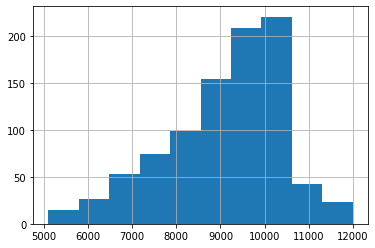

In [31]:
#how does avalanche likelyhood increase with elevation?
avy_data.Elevation.hist()

<AxesSubplot:>

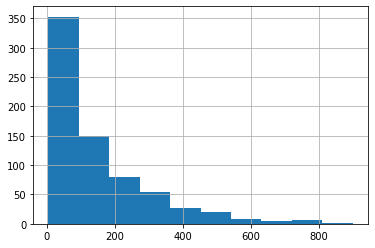

In [32]:
#what is the width of avalanches
avy_data.Width.hist()

<AxesSubplot:>

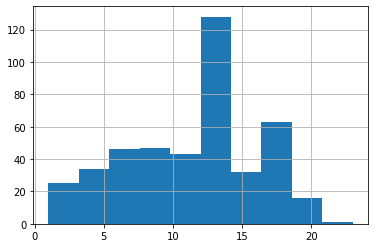

In [33]:
#what are the depths of avalanches this season
avy_data.Depth.hist()

In [34]:
#who observed the most avalanches
avy_data['Observer Name'].value_counts().head(20)

weed                              38
Trenbeath                         21
Bill Nalli                        16
Brett Kobernik                    13
B                                 12
Toby Weed                         11
Staples et al                      8
Torrey                             8
Weed                               8
Chris Benson                       7
Bill Brandt                        7
weed, pagnucco                     6
Katz                               6
Staples                            6
Wolford                            6
Staples/Osbourne/Deutschlander     5
CB                                 5
Joe                                5
Dave Jarvis                        5
UAC Staff                          5
Name: Observer Name, dtype: int64

<AxesSubplot:>

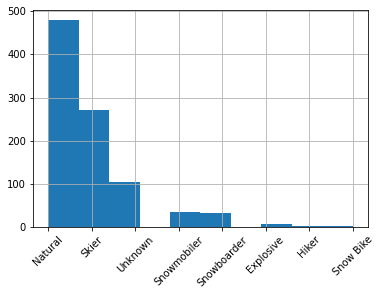

In [35]:
#What triggered these avalanches
avy_data['Trigger'].hist(xrot=45)

<AxesSubplot:>

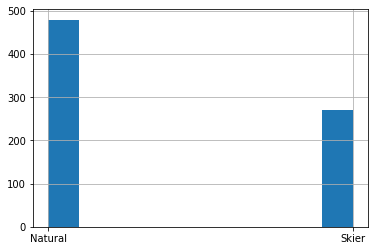

In [36]:
#closer look at Skier vs natural avalanches.
avy_data[avy_data['Trigger'].isin(['Skier', 'Natural'])]['Trigger'].hist()

In [37]:
# Out of the avalanches how many are carried
n_carried = avy_data['Carried'].value_counts().sum()
n_avalanches = avy_data.shape[0]
print(f"Out of {n_avalanches} reported avalanches, there were {n_carried} people caught and carried.")

# How many skier triggered avalanches result in a person being carried. 
skier_triggered = avy_data[avy_data['Trigger'] == 'Skier'].shape[0]
skier_triggered_carried = avy_data[avy_data['Trigger'] == 'Skier']['Carried'].value_counts().sum()
print(f"Out of {skier_triggered} skier triggered avalanches, {skier_triggered_carried} of those skiers were carried by an avalanche.")

Out of 959 reported avalanches, there were 55 people caught and carried.
Out of 271 skier triggered avalanches, 39 of those skiers were carried by an avalanche.


#### General Observations
- Name
- Email
- Obs Date
- Location
- Weather
- Red Flags
- Avalanche Problem #1
- Avalanche Problem #2
- Snow Profile
- Comments

Observations generally have more complex data with a Weather section, Red Flags, Avalanche Problem, etc. So lets try and extract all the info we can from an a report ONLY if it's an avalanche report

## Collecting Avalanche Forecasts

Avalanche forecasts are quantized risk factors that are determined by the avalanche forecast professionals of the UAC. The risk factors range between 1-5 in severity: Low (1, Green), Moderate (2, Yellow), Considerable (3, Orange), High (4, Red), and Extreme! (5, Black). These are calculated by weighing various avalanche problems such as large storms which leads to storm slabs, persistant weak layers from weather variations, and sudden warming conditions which leads to wet slides. Each avalanche problem posted includes the information:

- Type (Rising Temps, New Snow, Depth Hoar)
- Location (Aspect and elevation in form of the compass rose. )
- Likelihood (5-point scale from Unlikely (1) to Likely (3) to Certain (5))
- Size (5-point scale from Small (1) to Medium (3) to Large (5))
- Description

This is the primary format of avalanche centers throughout the states and would be the most familiar one to present the findings and assesments we hope to generate from observations in a given day. To pick apart this we need to first figure out how to web scrape the Forecast page and the Archived forecast page which has forecasts accross the state starting from 2001 (https://utahavalanchecenter.org/archives/forecasts). The current forecasts are also displayed here.  

### Forecast List

Using the archive link (https://utahavalanchecenter.org/archives/forecasts) we can get forecasts from the present day to 2018. 

In [38]:
avy_center_url = 'http://utahavalanchecenter.org'
forecast_archive_url = avy_center_url + '/archives/forecasts'
page = requests.get(forecast_archive_url)
soup = BeautifulSoup(page.content, 'html.parser')
tbl = soup.find("table")
#print(tbl.dtype)
page_forecasts = pd.read_html(str(tbl),extract_links ='all')[0]
page_forecasts.head()

,"(Issued, None)","(, None)","(Forecaster, None)"
0,"(3/28/2023, None)","(Forecast: Provo Area Mountains, /forecast/pro...","(Drew Hardesty, None)"
1,"(3/28/2023, None)","(Forecast: Skyline Area Mountains, /forecast/s...","(Brett Kobernik, None)"
2,"(3/28/2023, None)","(Forecast: Ogden Area Mountains, /forecast/ogd...","(Drew Hardesty, None)"
3,"(3/28/2023, None)","(Forecast: Moab Area Mountains, /forecast/moab...","(Dave Garcia, None)"
4,"(3/28/2023, None)","(Forecast: Salt Lake Area Mountains, /forecast...","(Drew Hardesty, None)"


This is practically the same as collecting observation data except we just substitute the different urls. We had get_table_obs() before so lets make a get_forecasts()

In [39]:
def get_page_table(url):
    '''returns a dataframe of avalanche observations from url. Data in df
    includes Date, Region, Avalanche/Observation, (url) extension, and
    observor'''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    tbl=soup.find("table")
    page_obs = pd.read_html(str(tbl), extract_links='all')[0]
    page_obs = clean_page_obs(page_obs)
    return page_obs

def clean_page_obs(page_obs):
    '''Cleans up the html parser's interpretation of the observation list'''
    old_columns = page_obs.columns
    #change names 
    page_obs[['Date', 'a']]= pd.DataFrame(page_obs[old_columns[0]].tolist(), index=page_obs.index)
    page_obs[['Region', 'b']]= pd.DataFrame(page_obs[old_columns[1]].tolist(), index=page_obs.index)
    page_obs[['Observation Title', 'extension']]= pd.DataFrame(page_obs[old_columns[2]].tolist(), index=page_obs.index)
    page_obs[['Observer', 'd']]= pd.DataFrame(page_obs[old_columns[3]].tolist(), index=page_obs.index)
    #remove old columns & columns with none
    page_obs=page_obs.drop(old_columns, axis=1)
    page_obs=page_obs.drop(['a','b','d'], axis=1)
    return page_obs

page_obs = get_page_obs(observations_url)
page_obs.head()



,Date,Region,Observation Title,extension,Observer
0,3/27/2023,Salt Lake,Avalanche: Butler Fork,/avalanche/77487,Patty Pow Pow
1,3/27/2023,Salt Lake,Accident: Oquirrh Mountains,/avalanche/77465,UAC Staff
2,3/27/2023,Salt Lake,Avalanche: Little Superior,/avalanche/77464,slp
3,3/27/2023,Salt Lake,Observation: South Face,/observation/77463,W Ambler
4,3/27/2023,Salt Lake,Avalanche: Long John Silver,/avalanche/77461,VR


## Cataloging Data

As you may notice the time it takes to perform these functions is quite long. In order to make the subsequent inquiries a little faster we will store the data locally on the computer. The process could be further improved, deleting an inquiry after a month or so would save local space or to store the data in a data repository that can be accessed with SQL. 

#### Ideas
- Generate Forcast reports for each day and verify using actual report. 
- Analyze data from fatality reports
- Using coodinates of avalanches, find the slope angle.

#### TODO
- Get location data -> not working using Beautiful soup, try different html parser
- Begin processing observation reports
- Add the avalanche danger on each day (https://utahavalanchecenter.org/archives/forecasts)
- Generate functions that quickly fetch plots for data
- Store the data locally
- Format the graphs better
- Write a script for the web scraping before moving on to Forecasts
